## Recursive feature addition 

* Process 
  * Build a model with all features and calculate feature importance
  * Pick the most important feature and build a model (model 1)
  * Calculate the initial performance 
  * Add the second important feature and build a model (model 2)
  * If performance increase is bigger than threshold, it is an important feature, so keep it. If not, remove the feature. 
  * Repeat until all the features in the dataset is examined 



In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_auc_score, r2_score

# Classification

In [2]:
# load dataset
data = pd.read_csv('../datasets/dataset_1.csv')
data.shape


(50000, 301)

In [3]:
data.head()

,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,...,var_292,var_293,var_294,var_295,var_296,var_297,var_298,var_299,var_300,target
0,0,0,0.0,0.00,0.0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0.0,0.0000,0
1,0,0,0.0,3.00,0.0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0.0,0.0000,0
2,0,0,0.0,5.88,0.0,0,0,0,0,0,...,0.0,0,0,3,0,0,0,0.0,67772.7216,0
3,0,0,0.0,14.10,0.0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0.0,0.0000,0
4,0,0,0.0,5.76,0.0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0.0,0.0000,0


In [4]:

# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),
    data['target'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((35000, 300), (15000, 300))

## Remove constant and quasi-constant features

In [5]:
# to speed things up we remove constant, quasi-constand and duplicated features

quasi_constant_feat = []

# iterate over every feature
for feature in X_train.columns:

    # find the predominant value, that is the value that is shared
    # by most observations
    predominant = (X_train[feature].value_counts() / np.float(
        len(X_train))).sort_values(ascending=False).values[0]

    # evaluate the predominant feature: do more than 99% of the observations
    # show 1 value?
    if predominant > 0.998:
        
        # if yes, add the variable to the list
        quasi_constant_feat.append(feature)

X_train.drop(labels=quasi_constant_feat, axis=1, inplace=True)
X_test.drop(labels=quasi_constant_feat, axis=1, inplace=True)

X_train.shape, X_test.shape

((35000, 158), (15000, 158))

## Remove duplicated

In [6]:
duplicated_feat = []
for i in range(0, len(X_train.columns)):
    if i % 10 == 0:  # this helps me understand how the loop is going
        print(i)

    col_1 = X_train.columns[i]

    for col_2 in X_train.columns[i + 1:]:
        if X_train[col_1].equals(X_train[col_2]):
            duplicated_feat.append(col_2)
            
len(duplicated_feat)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150


6

In [7]:
# remove duplicated features
X_train.drop(labels=duplicated_feat, axis=1, inplace=True)
X_test.drop(labels=duplicated_feat, axis=1, inplace=True)

X_train.shape, X_test.shape

((35000, 152), (15000, 152))

## Train a ML model with all features

In [8]:
# build initial model using all the features
model_full = GradientBoostingClassifier(n_estimators=10, max_depth=4, random_state=10)

model_full.fit(X_train, y_train)

# calculate the roc-auc in the test set
y_pred_test = model_full.predict_proba(X_test)[:, 1]
roc_full = roc_auc_score(y_test, y_pred_test)

print('Test ROC AUC=%f' % (roc_full))

Test ROC AUC=0.827532


Text(0.5, 0, 'Feature')

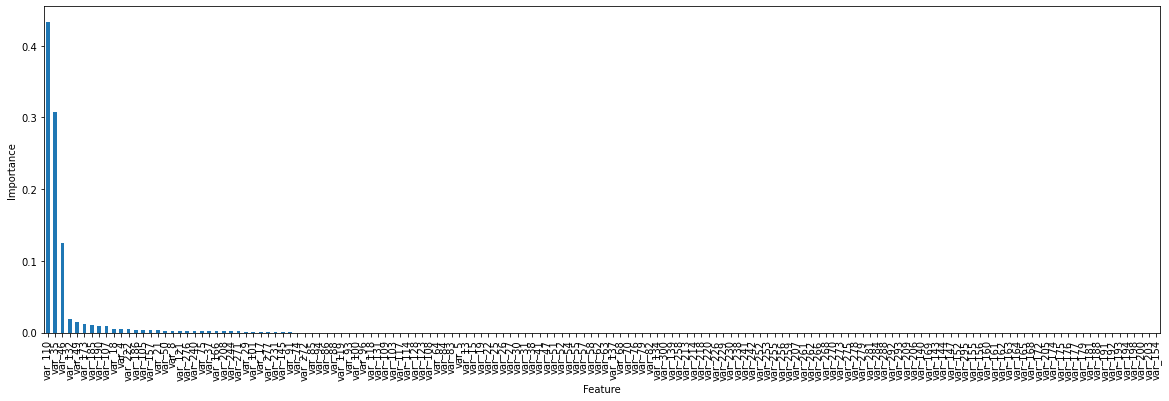

In [12]:
# get feature name and importance
features = pd.Series(model_full.feature_importances_)
features.index = X_train.columns

# sort the features by importance
features.sort_values(ascending=False, inplace=True)

# plot
features.plot.bar(figsize=(20,6))
plt.ylabel('Importance')
plt.xlabel('Feature')

In [13]:
# make list of ordered features
features = list(features.index)

## Build a ML model with 1 feature

In [14]:
# build initial model using all the features
model_one_feature = GradientBoostingClassifier(n_estimators=10, max_depth=4, random_state=10)

# train using only the most important feature
model_one_feature.fit(X_train[features[0]].to_frame(), y_train)

# calculate the roc-auc in the test set
y_pred_test = model_one_feature.predict_proba(X_test[features[0]].to_frame())[:, 1]

roc_first = roc_auc_score(y_test, y_pred_test)

print('Test one feature xgb ROC AUC=%f' % (roc_first))

Test one feature xgb ROC AUC=0.700436


## Select features

In [15]:
# recursive feature addition:

# first we arbitrarily set the increase in roc-auc
# if the increase is above this threshold,
# the feature will be kept
tol = 0.0001

print('doing recursive feature addition')

# we initialise a list where we will collect the
# features we should keep
features_to_keep = [features[0]]

# set a counter to know which feature is being evaluated
count = 1

# now we loop over all the features, in order of importance:
# remember that features in the list are ordered
# by importance
for feature in features[1:]:
    print()
    print('testing feature: ', feature, count, ' out of ', len(features))
    count = count + 1

    # initialise model
    model_int = GradientBoostingClassifier(n_estimators=10, max_depth=4, random_state=10)

    # fit model with the selected features
    # and the feature to be evaluated
    model_int.fit(
        X_train[features_to_keep + [feature] ], y_train)

    # make a prediction over the test set
    y_pred_test = model_int.predict_proba(
        X_test[features_to_keep + [feature] ])[:, 1]

    # calculate the new roc-auc
    roc_int = roc_auc_score(y_test, y_pred_test)
    print('New Test ROC AUC={}'.format((roc_int)))

    # print the original roc-auc with one feature
    print('Previous round Test ROC AUC={}'.format((roc_first)))

    # determine the increase in the roc-auc
    diff_roc = roc_int - roc_first

    # compare the increase in roc-auc with the tolerance
    # we set previously
    if diff_roc >= tol:
        print('Increase in ROC AUC={}'.format(diff_roc))
        print('keep: ', feature)
        print
        # if the increase in the roc is bigger than the threshold
        # we keep the feature and re-adjust the roc-auc to the new value
        # considering the added feature
        roc_first = roc_int
        
        # and we append the feature to keep to the list
        features_to_keep.append(feature)
    else:
        # we ignore the feature
        print('Increase in ROC AUC={}'.format(diff_roc))
        print('remove: ', feature)
        print

# now the loop is finished, we evaluated all the features
print('DONE!!')
print('total features to keep: ', len(features_to_keep))

doing recursive feature addition

testing feature:  var_35 1  out of  152
New Test ROC AUC=0.8126631456095583
Previous round Test ROC AUC=0.7004355259402437
Increase in ROC AUC=0.1122276196693146
keep:  var_35

testing feature:  var_46 2  out of  152
New Test ROC AUC=0.8179917540572695
Previous round Test ROC AUC=0.8126631456095583
Increase in ROC AUC=0.005328608447711214
keep:  var_46

testing feature:  var_132 3  out of  152
New Test ROC AUC=0.819437196040365
Previous round Test ROC AUC=0.8179917540572695
Increase in ROC AUC=0.0014454419830954857
keep:  var_132

testing feature:  var_49 4  out of  152
New Test ROC AUC=0.8196620237318119
Previous round Test ROC AUC=0.819437196040365
Increase in ROC AUC=0.00022482769144682724
keep:  var_49

testing feature:  var_173 5  out of  152
New Test ROC AUC=0.823239485575252
Previous round Test ROC AUC=0.8196620237318119
Increase in ROC AUC=0.0035774618434400995
keep:  var_173

testing feature:  var_185 6  out of  152
New Test ROC AUC=0.82179901

New Test ROC AUC=0.8294359809082971
Previous round Test ROC AUC=0.8293869234834164
Increase in ROC AUC=4.905742488070519e-05
remove:  var_109

testing feature:  var_103 47  out of  152
New Test ROC AUC=0.8293869234834164
Previous round Test ROC AUC=0.8293869234834164
Increase in ROC AUC=0.0
remove:  var_103

testing feature:  var_117 48  out of  152
New Test ROC AUC=0.8293869234834164
Previous round Test ROC AUC=0.8293869234834164
Increase in ROC AUC=0.0
remove:  var_117

testing feature:  var_114 49  out of  152
New Test ROC AUC=0.8294359809082971
Previous round Test ROC AUC=0.8293869234834164
Increase in ROC AUC=4.905742488070519e-05
remove:  var_114

testing feature:  var_128 50  out of  152
New Test ROC AUC=0.8294359809082971
Previous round Test ROC AUC=0.8293869234834164
Increase in ROC AUC=4.905742488070519e-05
remove:  var_128

testing feature:  var_123 51  out of  152
New Test ROC AUC=0.8293869234834164
Previous round Test ROC AUC=0.8293869234834164
Increase in ROC AUC=0.0
remo

New Test ROC AUC=0.8297325296506355
Previous round Test ROC AUC=0.8297325296506355
Increase in ROC AUC=0.0
remove:  var_230

testing feature:  var_238 94  out of  152
New Test ROC AUC=0.8297325296506355
Previous round Test ROC AUC=0.8297325296506355
Increase in ROC AUC=0.0
remove:  var_238

testing feature:  var_241 95  out of  152
New Test ROC AUC=0.8297325296506355
Previous round Test ROC AUC=0.8297325296506355
Increase in ROC AUC=0.0
remove:  var_241

testing feature:  var_242 96  out of  152
New Test ROC AUC=0.8297325296506355
Previous round Test ROC AUC=0.8297325296506355
Increase in ROC AUC=0.0
remove:  var_242

testing feature:  var_252 97  out of  152
New Test ROC AUC=0.8297325296506355
Previous round Test ROC AUC=0.8297325296506355
Increase in ROC AUC=0.0
remove:  var_252

testing feature:  var_253 98  out of  152
New Test ROC AUC=0.8295875615690463
Previous round Test ROC AUC=0.8297325296506355
Increase in ROC AUC=-0.00014496808158914742
remove:  var_253

testing feature:  va

New Test ROC AUC=0.8297325296506355
Previous round Test ROC AUC=0.8297325296506355
Increase in ROC AUC=0.0
remove:  var_179

testing feature:  var_181 142  out of  152
New Test ROC AUC=0.8291682562289647
Previous round Test ROC AUC=0.8297325296506355
Increase in ROC AUC=-0.0005642734216707579
remove:  var_181

testing feature:  var_188 143  out of  152
New Test ROC AUC=0.8280919883234286
Previous round Test ROC AUC=0.8297325296506355
Increase in ROC AUC=-0.0016405413272069236
remove:  var_188

testing feature:  var_191 144  out of  152
New Test ROC AUC=0.8286285115197345
Previous round Test ROC AUC=0.8297325296506355
Increase in ROC AUC=-0.0011040181309009967
remove:  var_191

testing feature:  var_192 145  out of  152
New Test ROC AUC=0.8297325296506355
Previous round Test ROC AUC=0.8297325296506355
Increase in ROC AUC=0.0
remove:  var_192

testing feature:  var_193 146  out of  152
New Test ROC AUC=0.8297325296506355
Previous round Test ROC AUC=0.8297325296506355
Increase in ROC AUC=

In [16]:
# build initial model
model_final = GradientBoostingClassifier(n_estimators=10, max_depth=4, random_state=10)

# fit the model with the selected features
model_final.fit(X_train[features_to_keep], y_train)

# make predictions
y_pred_test = model_final.predict_proba(X_test[features_to_keep])[:, 1]

# calculate roc-auc
roc_final = roc_auc_score(y_test, y_pred_test)
print('Test selected features ROC AUC=%f' % (roc_final))

Test selected features ROC AUC=0.829733
